# Exploratory Data Analysis with OSRS prices
## About the project:
The objective is to make money by buying items for a low price and selling them at a higher price. This requires predicting item prices. 

Can we use XP data and previous prices to predict future prices?

## About the data:
 - Data is collected daily from from Oct 25th 2022 to current day.
 - Price data [source](http://services.runescape.com) and XP data [source](https://www.crystalmathlabs.com/tracker/api.php)
 - Unsure if price data is latest price in the hour or the average of the prices in the last hour
 - No missing data
 
## Analysis steps
### Stationary Check
Most time series techniques require data that is stationary:
 - Constant mean
 - Constant variance

Stationary tests:
 - Autocorrelation: the correlation a time series has with one of its lags
 - Partial autocorrelation: the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes

Achieving stationary:
 - Differencing (first-order, second-order, seasonal etc..)
 - Log transform
 

### Dependent Variable Analysis
Let's analyze the variable that we're trying to predict.

#### Trend analysis
Let's first observe if any items have any definite trends. The data covers a short period of time. We won't be able to see any long term trends. 
 - Moving average plots
 - Linear regression and forecasting with Deterministic Process

#### Seasonal/Cyclical analysis
We cannot do a seasonal analysis as we do not have enough data. Instead, we can look for cyclical weekly trends.
 - Cyclical plot for weekly periods
 - Periodogram for weekly and semi-weekly periods
 - Forecasting with Deterministic Process
 
#### 



#### References 
 - [Kaggle Learn Time Series Tutorial](https://www.kaggle.com/learn/time-series)
 - 



In [12]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

import re

simplefilter("ignore")

In [13]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

## Analysis Steps

In [25]:
def read_csv(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    
    df['date'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('date', inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    
    #column = re.search('/(.*)_', filename).group(1)
    #df['total_' + column] = df.sum(axis=1)
    
    return df

df_logs = read_csv('data/Log_Prices.csv')
df_ores = read_csv('data/Ore_Prices.csv')
df_runes = read_csv('data/Rune_Prices.csv')
df_seeds = read_csv('data/Seed_Prices.csv')
df_xp = read_csv('data/XP_Data.csv')

assert df_logs.shape[0] == df_ores.shape[0] == df_runes.shape[0] == df_seeds.shape[0] == df_xp.shape[0], "# Rows should match in all dfs"
df = pd.concat([df_logs, df_ores, df_runes, df_seeds, df_xp], axis=1, join="outer")
#df = pd.concat([df_logs, df_xp], axis=1, join="outer")

assert df.isna().sum().sum() == 0, "There should not be any NaN"
df.head()

,logs,magic_logs,yew_logs,maple_logs,willow_logs,oak_logs,copper_ore,tin_ore,iron_ore,silver_ore,...,magic,fletching,woodcutting,firemaking,construction,farming,herblore,thieving,mining,smithing
date,,,,,,,,,,,,,,,,,,,,,
2022-10-24 12:00:00,75,1067,210,7,29,54,55,63,115,56,...,205451414,92768099,138258734,75298264,63783051,141767970,78795413,102010451,92151515,58125235
2022-10-25 12:00:00,73,1069,209,7,29,54,55,65,117,57,...,199800520,103128682,138089900,82579582,59902090,139626873,67355860,110891183,95542823,72236021
2022-10-26 12:00:00,73,1069,209,7,29,54,55,65,117,57,...,199002232,80769819,133333057,73917130,67326388,137205842,63921858,104089075,88686893,70714696
2022-10-27 12:00:00,73,1086,210,7,29,59,56,67,121,57,...,186273776,88484089,129388191,70880144,55083558,136371445,62341126,100542176,89210874,69827625
2022-10-28 12:00:00,76,1077,212,7,30,62,57,66,128,57,...,192188657,69707057,129316623,75238824,53681187,139637930,70588559,100696372,100440170,77573435


array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>

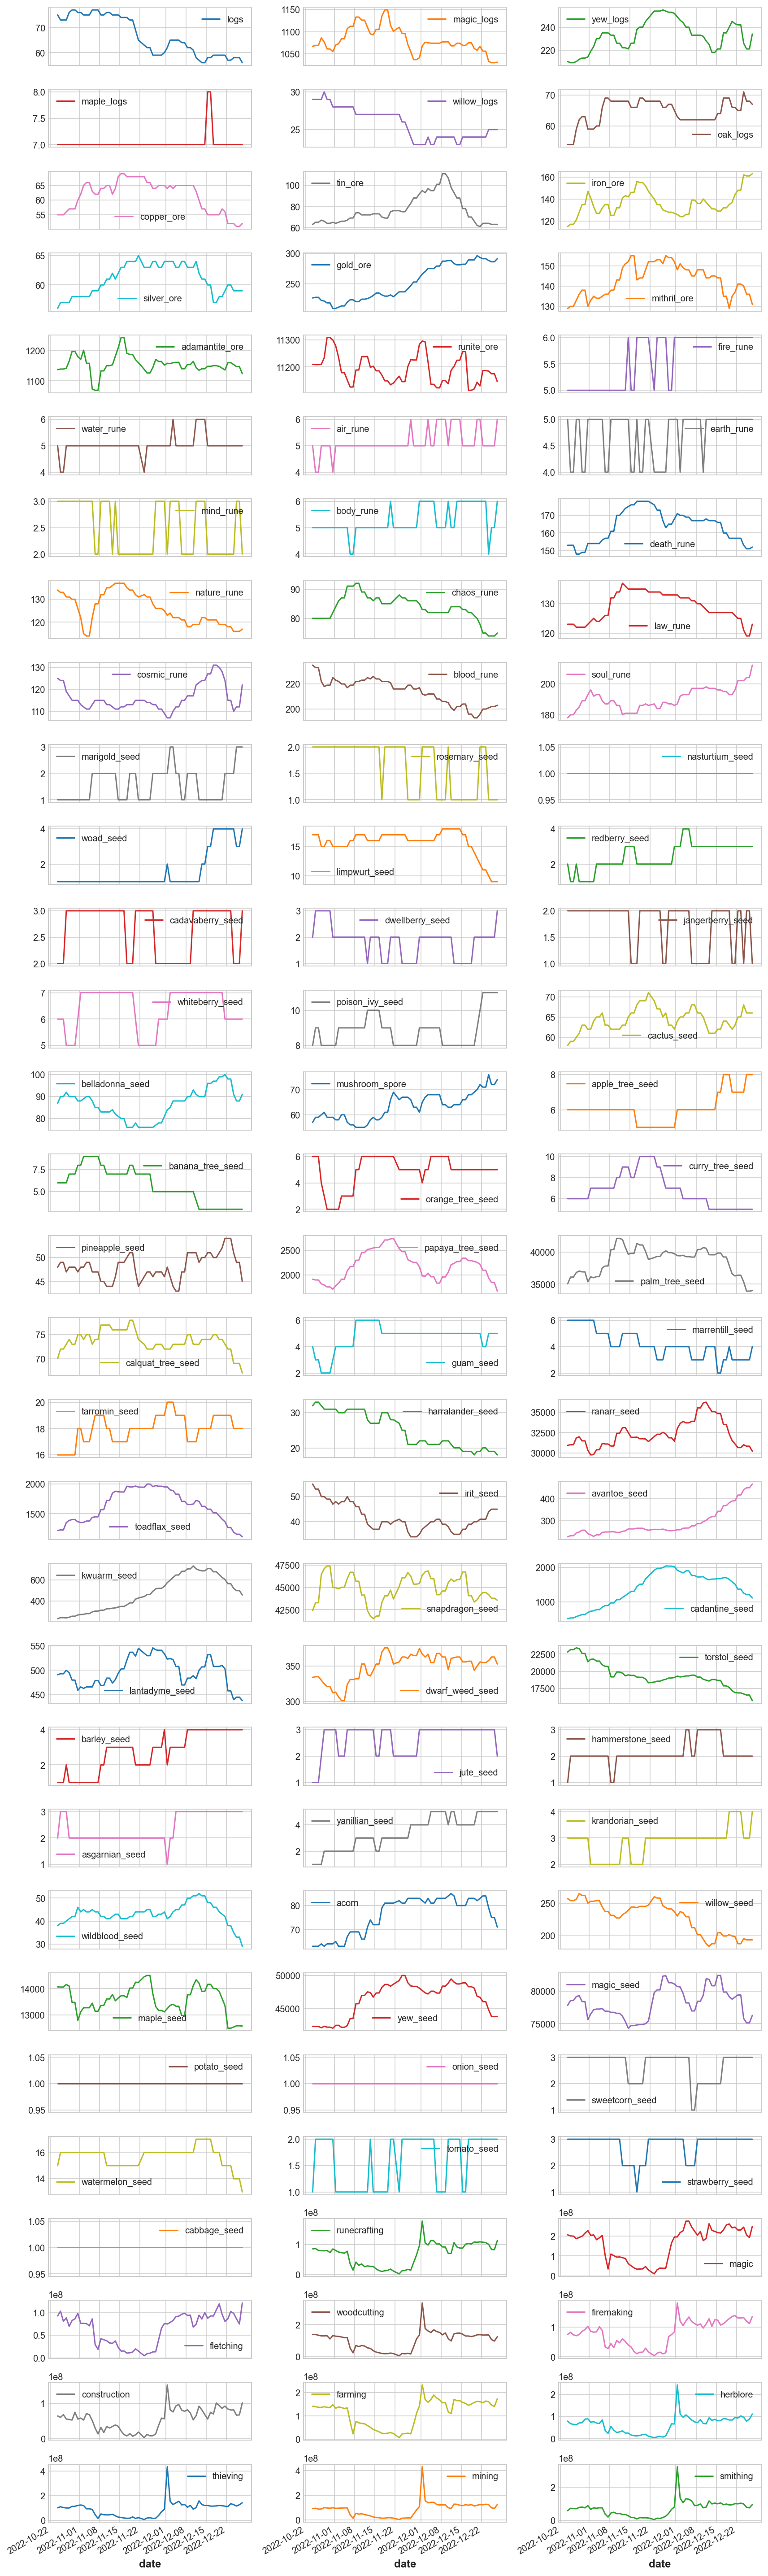

In [28]:
df.plot(subplots=True, figsize=(12, 40), layout=(len(df.columns)//3, 3))

There are a lot of items to consider. We need to filter some of them.

The total gains endpoint tracks XP for all players who are registered at CML. Ideally we should split the XP gained by level because it would correlate to specific items better. For example, a level 98 woodcutter will probably have no effect on Maple logs. Instead we can maybe filter items with some assumptions about the available data.

We can assume that most of the XP players are high level and we should cover some high level training methods. We'll check out the wiki to see the fastest training methods for both F2P and P2P.

| Skill | F2P methods | P2P methods | Comment |
| :-- | :--- | :--- | :--- |
| Runecrafting | Tiara's, Body runes | Lava, Blood, Soul Runes |  |
| Magic | TK Grab, Curse, High Alch, TP, Splashing | Enchants | Corresponding runes include Cosmic, Law, Nature, Mind, Chaos, Death Runes | 
| Fletching | Feathers, Bowstring, Headless arrows | |  |
| Woodcutting | Yew, Maple, Willow Logs | Redwood, Teak Logs | |
| Firemaking | Yew, Magic | Wintertodt, Redwood | | 
| Construction |  | Steel nails, Oak, Teak, Mahogany |  |  
| Farming | | | Magic, Dragonfruit, Mahogany, Redwood | Seeds but not logs | 
| Herblore | | Limpwurt root, Snapegrass, Volcanic ash, Mort myre fungus, Potato cactus, Crushed nest, Torstol  | This one has a lot more items. I will only consider the items with a higher daily volume and that have a reasonable dependence on the features |
| Thieving | | Seeds, Bloodshard, Blood runes, Death runes, Enhanced crystal teleport seed | Farmers, Vyres, and elves are high level pickpocket targets |
| Mining | Iron ore | Iron, Granite, | |
| Smithing | Iron, Steel, Mithril, Adamant, Rune bars | Gold bars | |


With this table we can cut down our list of items and their dependencies to the following.

| Items | Dependence | Comment |
| :--  | :--------- | :------ |
| Body, Lava, Soul, Cosmic, Law, Nature, Mind, Chaos | Runecrafting/Magic | | 
| Blood, Death runes | Runecrafting/Magic/Thieving | | 
| Feathers, Bowstring, Headless arrows | Fletching |
| Yew, Magic, Maple, Willow Logs | Woodcutting/Firemaking |
| Redwood, Teak Logs |  Woodcutting/Firemaking | No data :( |
| Steel nails | Construction/Mining/Smithing | No data :( |
| Oak, Teak, Mahogany Planks | Woodcutting/Construction | No data :( |
| Magic, Dragonfruit, Mahogany, Redwood seeds | Farming/Thieving | | 
| Limpwurt root, Snapegrass, Mort myre fungus, Torstol, Potato cactus, Crushed nest| Herblore/Farming/Thieving |  |
| Volcanic Ash | Herblore/Mining | |
| Bloodshard/Enhanced crystal teleport seed | Thieving | |
| Iron ore/Granite | Mining/Smithing | |
| Iron, Steel, Mithril, Adamant, Rune, Gold bars | Mining/Smithing | |

In [9]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    n = len(x)-lag
    se = ((1-corr**2)/(n-2))**0.5
    
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}±{se:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def plot_all(df, column):

    weekly = pd.date_range(start='2022-10-23', end=datetime.today(), freq='W')
    monthly = pd.date_range(start='2022-10-23', end=datetime.today(), freq='M')

    ax = df[column].plot(title=column, **plot_params)
    ax.set_ylabel('Prices')
    ax.vlines(weekly, df[column].min(), df[column].max(), linestyles='dashed', color='blue')
    ax.vlines(monthly, df[column].min(), df[column].max(), linestyles='dashed', color='red')
    
    _ = plot_pacf(df[column], lags=31)
    _ = plot_lags(df[column], lags=31, nrows=6)

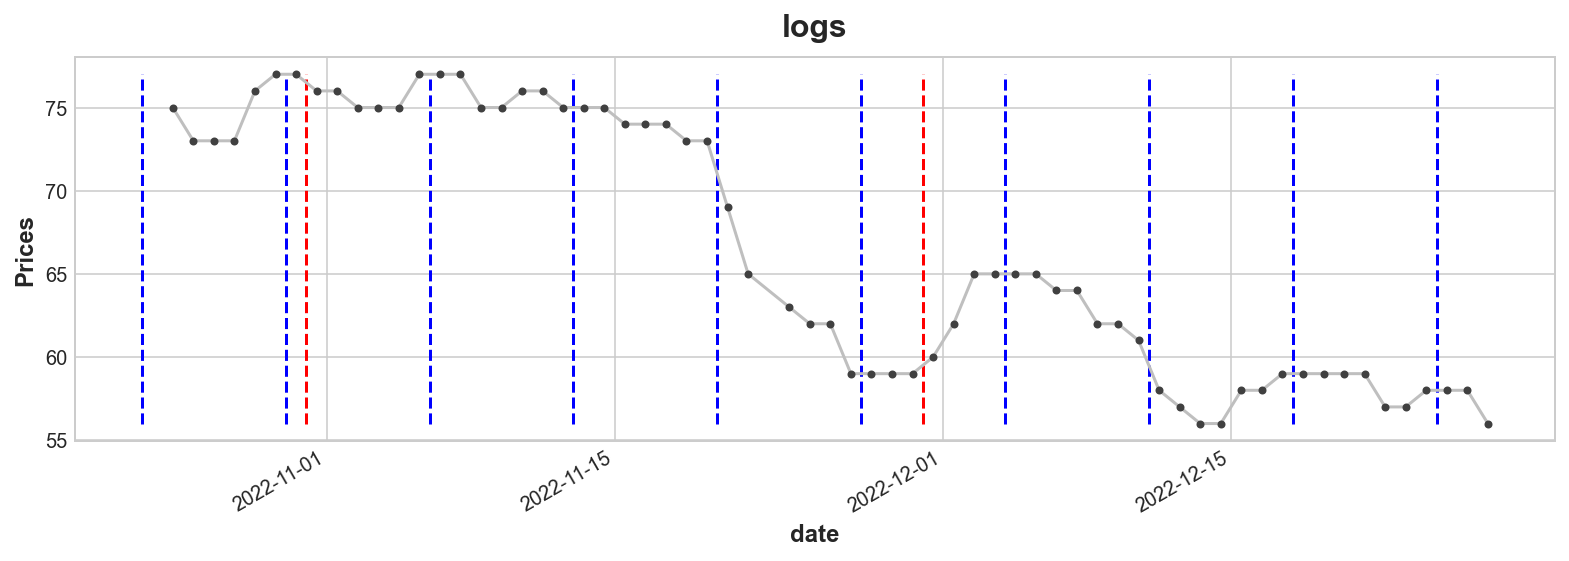

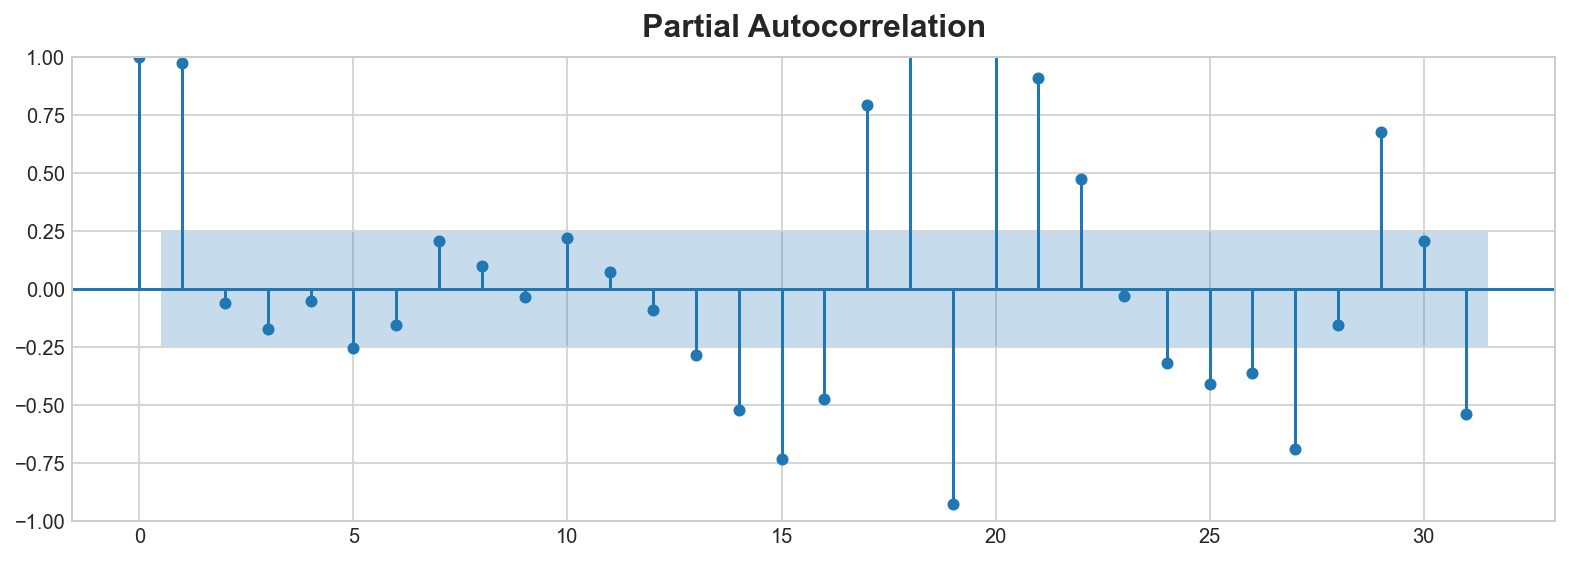

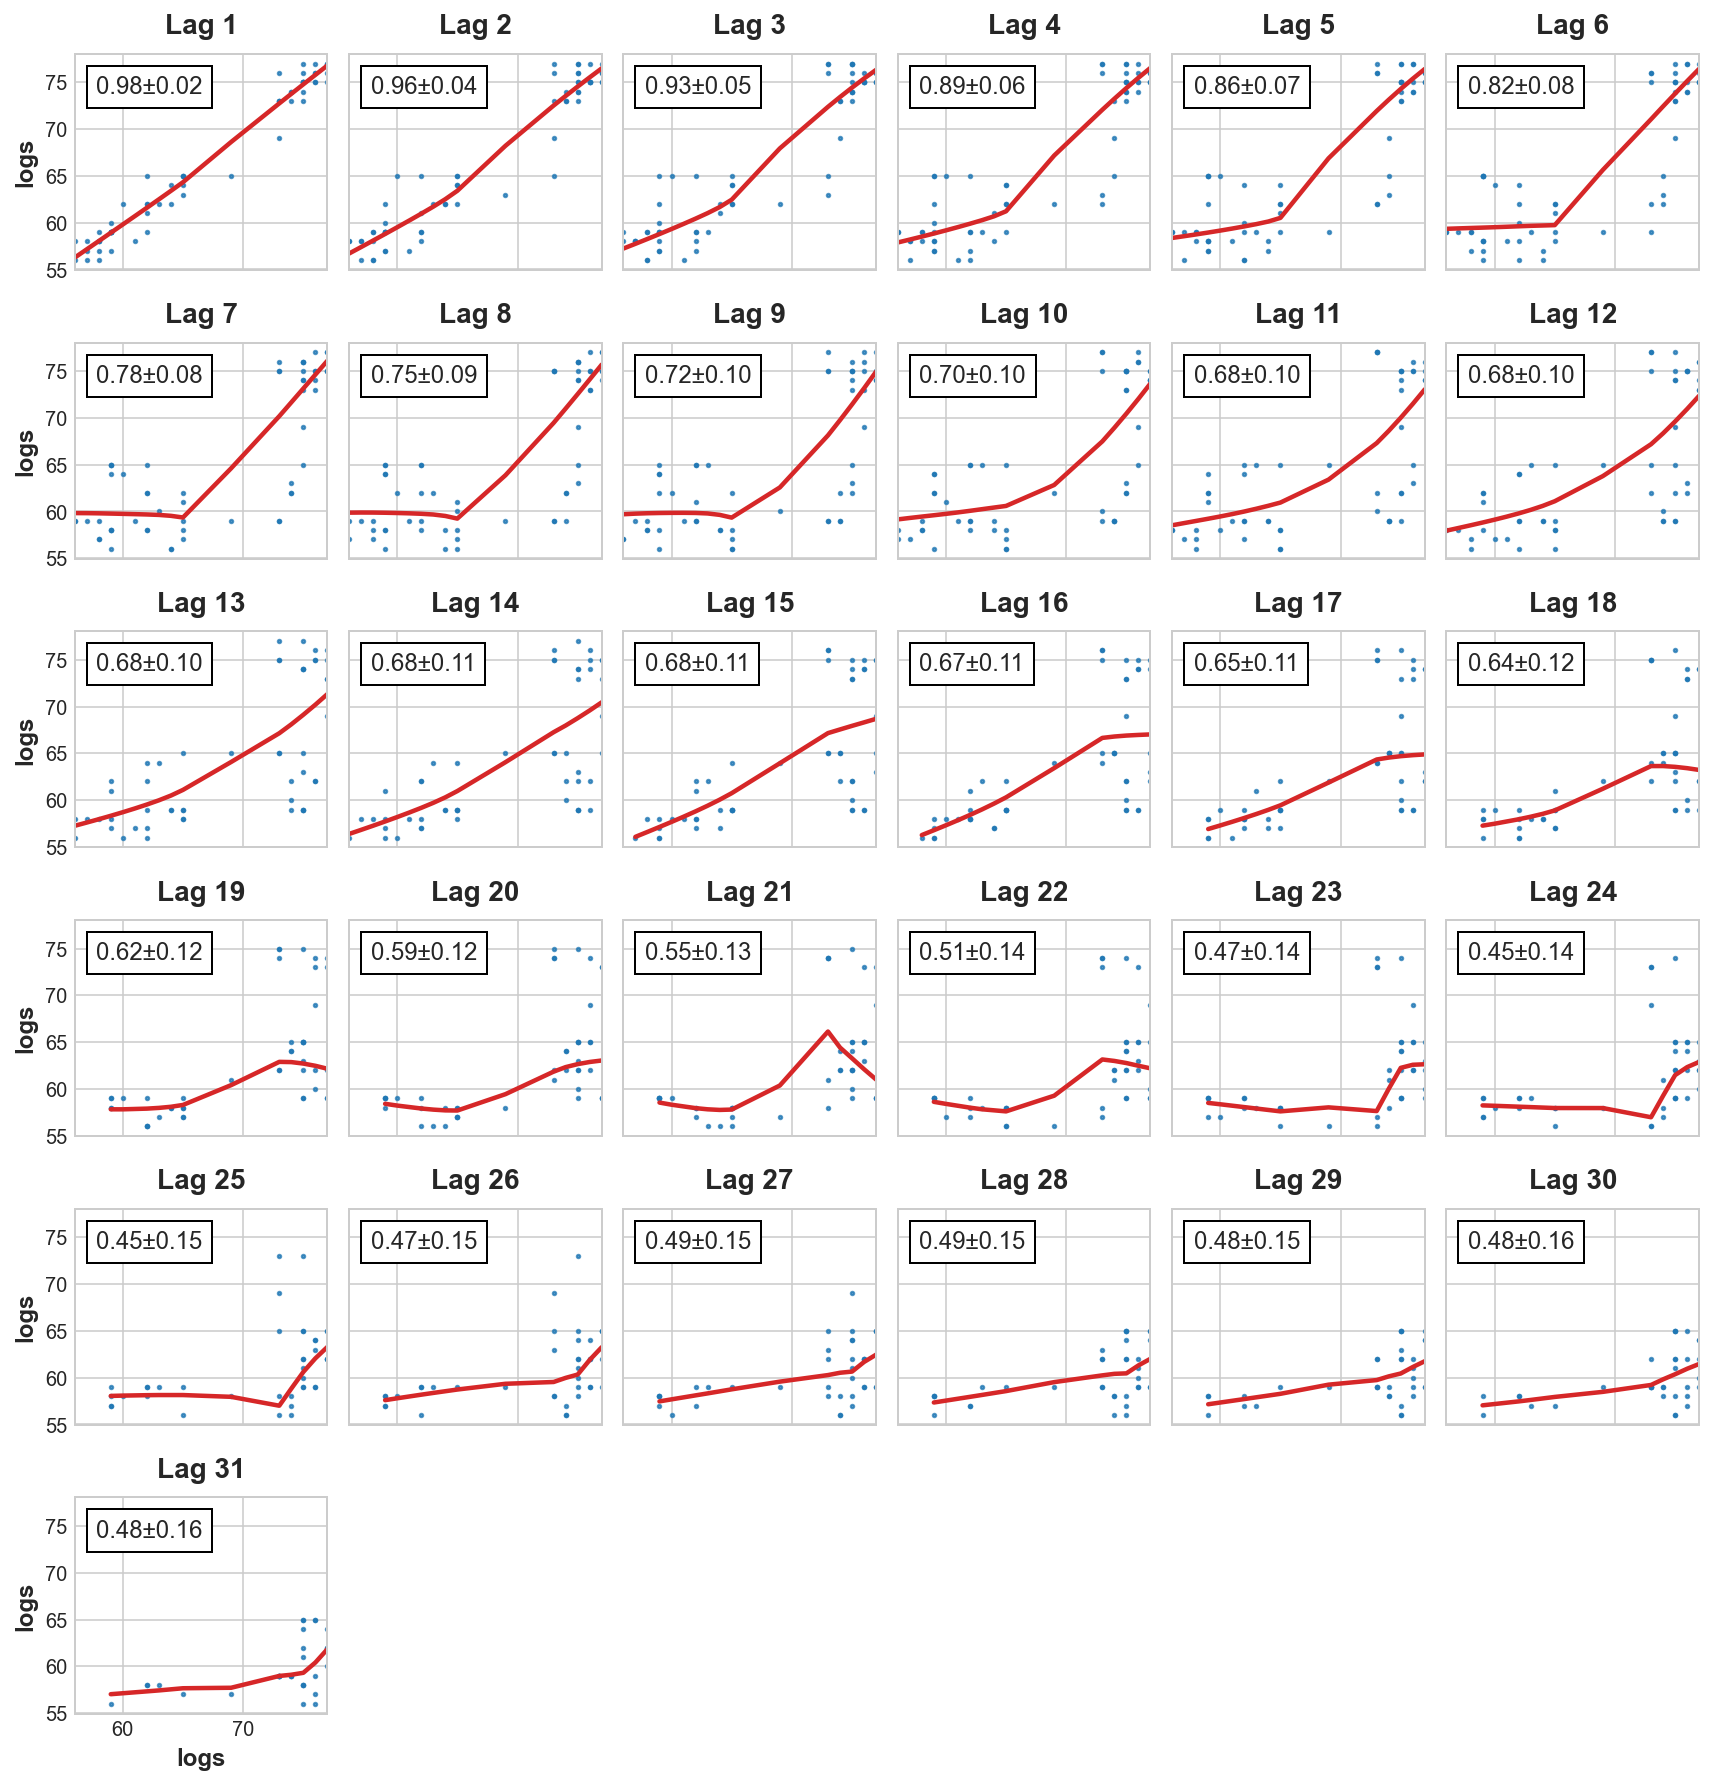

In [10]:
plot_all(df, 'logs')

| Item | Price | PACF | Lag | Comment |
| :--: | :---: | :--: | :-: | :-----: |
| Log  | No trend | 1, 13-22, 24-27, 29, 31 | Non-linear reltionships after lag 3. | Only 1 should be usable.    |
| 



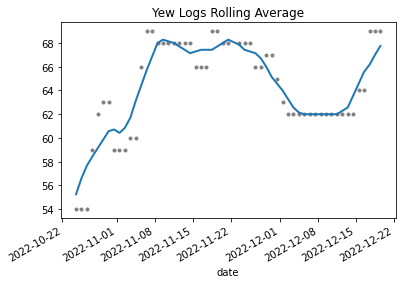

In [50]:
moving_average = df['oak_logs'].rolling(
    window=7,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=3,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df['oak_logs'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=2, title="Yew Logs Rolling Average", legend=False,
);

In [32]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

<ipython-input-51-3626b6be096c>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week #pd.Int64Index(X.index.isocalendar().week) # the seasonal period (period)


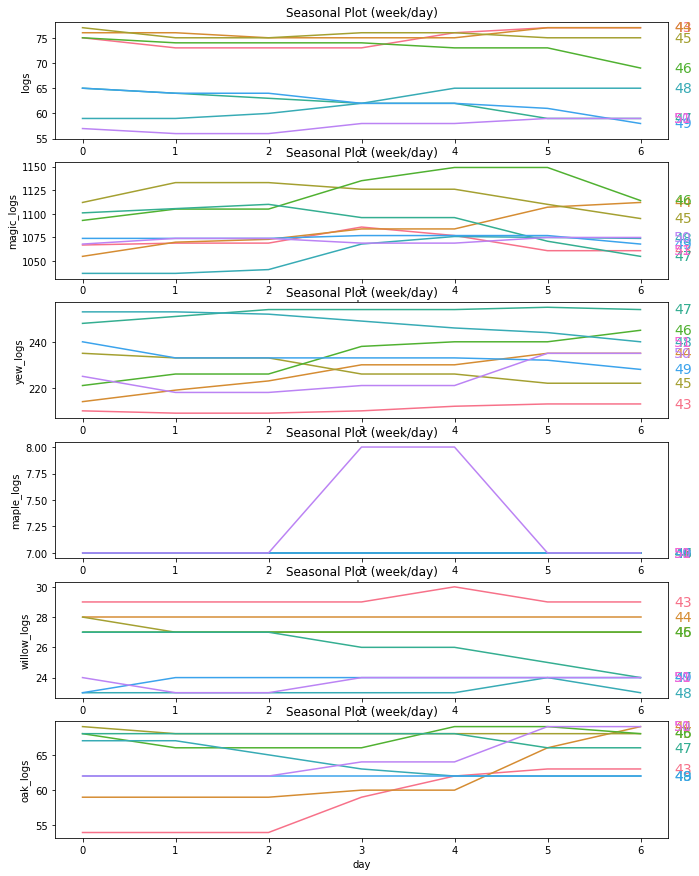

In [51]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = pd.Int64Index(X.index.isocalendar().week) # the seasonal period (period)

columns = df.columns
fig, axes = plt.subplots(len(columns), 1, figsize=(11, 15))

for i, column in enumerate(columns):
    seasonal_plot(X, y=column, period="week", freq="day", ax=axes[i])

#